In [437]:
import time
import numpy as np
import gym
from gym import spaces
from collections import defaultdict
import math
import itertools
from matplotlib import pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import plotly.graph_objects as go
import copy

# Environment

In [613]:
class SmartCharging(gym.Env):
    def __init__(self, actions, cap, stuck_penalty, sequential_after_num_iterations):
        super(SmartCharging, self).__init__()
        
        self.actions = actions  
        self.cap = cap
        self.stuck_penalty = stuck_penalty
        self.sequential_after_num_iterations = sequential_after_num_iterations
        
        self.episode = 0
        self.old_level = 0
        self.stuck = False
        self.action_space = spaces.Discrete(len(self.actions))
        self.observation_space = spaces.Dict({
            'level': spaces.Discrete(self.cap+1),
            'time': spaces.Discrete(8)
        })
        
        self.state = {
            'level': 0,
            'time': 0
        }      
        
        self.done = False
        
    def reset(self):
        self.state = {
            'level': self.old_level,
            'time': 0
        }
        self.done = False
        return self.state
    
    def reset_random(self):
        self.state = {
            'level': np.random.randint(0,100),
            'time': np.random.randint(0,7)
        }
        self.done = False
        return self.state

    def reset_episode(self): #Call this after every training!
        self.episode=0

    def step(self, action):
        loaded = self.actions.get(action)
        reward = 0

        if loaded + self.state['level'] > self.cap:
            reward -= cost_func(self.state['time'], self.cap - self.state['level'])
            self.state['level'] = self.cap
        else:
            reward -= cost_func(self.state['time'], loaded)
            self.state['level'] += loaded

        self.state['time'] += 1

        if self.state['time'] == 8:
            consumed = power_consumed()
            if self.state['level'] - consumed >= 0:
                self.old_level = self.state['level'] - consumed
                self.stuck = False
            else:
                self.old_level = 0
                self.stuck = True
                reward += self.stuck_penalty
                
            self.reset()
                
            self.episode += 1
            self.done = True
            
        return self.state, reward, self.done, self.stuck
    
def cost_func(t, p):
    '''
    This method returns the costs for charging
    @param t:  time
    @param p:  charging rate
    '''
    # alpha_time is the coefficient for time
    alpha_time = [1, 1, 1, 1, 1, 1, 1, 1] 
    return alpha_time[t] * p**2

def power_consumed(mu=30, sigma=10):
    '''
    This method returns power consumed by the taxi driver
    @param mu: mean
    @param sigma: standard deviation
    '''
    return int(np.random.normal(mu, sigma, 1)[0])

def plot_q_table_3d(q_table,cap):
    
    def get_Z(key):
        #return max(q_table[key])
        return np.average(q_table[key])
        
    # battery level
    X = np.arange(cap +1)
    # time
    Y = np.arange(8)
    X_grid, Y_grid = np.meshgrid(X, Y)
    # max q-values (policy)
    Z = np.array([get_Z(key) for key in itertools.product(Y,X)]).reshape((8,cap+1))

    fig = plt.figure(figsize=(10, 10))

    # Add a 3D subplot
    #ax = [fig.add_subplot(1, 3, i, projection='3d') for i in range(1, 4)]
    ax = fig.add_subplot(111, projection='3d')
    
    ax.plot_surface(X_grid, Y_grid, -Z, cmap='viridis')

    ax.view_init(elev=30, azim=45)

    ax.set_zlabel('max Q-value')
    ax.set_ylabel('Time')
    ax.set_xlabel('Battery level')
    plt.tight_layout()
    plt.show()

def plot_q_table_2d(q_table):
    """
    Plot average Q-values over all actions for each state in the Q-table
    
    Parameters:
    - q_table (dict): The Q-table where keys are state tuples and values are lists/arrays of Q-values for different actions
    """
    levels = sorted(set(state[1] for state in q_table.keys()))
    times = sorted(set(state[0] for state in q_table.keys()))
    
    #default 0,0 matrix
    q_matrix = np.zeros((len(levels), len(times)))

    # Fill matrix with average Q-values
    for state_key, q_values in q_table.items():
        time, level = state_key
        if level in levels and time in times:
            level_idx = levels.index(level)
            time_idx = times.index(time)
            q_matrix[level_idx, time_idx] = np.mean(q_values)


    fig, ax = plt.subplots(figsize=(len(times), len(levels)))
    cax = ax.matshow(q_matrix, cmap='viridis')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(times)))
    ax.set_xticklabels(times)
    ax.set_yticks(np.arange(len(levels)))
    ax.set_yticklabels(levels)

    #Annotation
    for i in range(len(levels)):
        for j in range(len(times)):
            value = q_matrix[i, j]
            ax.text(j, i, f"{value:.2f}", ha='center', va='center', color='white')

    ax.set_xlabel('Time')
    ax.set_ylabel('Level')
    plt.title('Average Q-Value')
    plt.show()
    
def plot_greedy_policy(q_table):
    """
    Plot the actions with the max Q-values for each state in the Q-table.
    
    Parameters:
    - q_table (dict): The Q-table where keys are state tuples and values are lists/arrays of Q-values for different actions.
    """
    
    action_labels = {0: 'None', 1: 'Low', 2: 'Medium', 3: 'High', 4: 'Very high'}
    
    levels = sorted(set(state[1] for state in q_table.keys()))
    times = sorted(set(state[0] for state in q_table.keys()))
    
    action_matrix = np.zeros((len(levels), len(times)))

    for state_key, q_values in q_table.items():
        time, level = state_key
        if level in levels and time in times:
            level_idx = levels.index(level)
            time_idx = times.index(time)
            best_action = np.argmax(q_values)
            action_matrix[level_idx, time_idx] = best_action

    fig, ax = plt.subplots(figsize=(12, 8)) 
    cax = ax.matshow(action_matrix, cmap='viridis', vmin=0, vmax=len(action_labels)-1)

    cbar = fig.colorbar(cax, ticks=list(action_labels.keys()))
    cbar.ax.set_yticklabels([action_labels[i] for i in action_labels.keys()])

    xticks = np.arange(len(times))
    yticks = np.arange(len(levels))
    
    y_ticks_interval = max(1, len(levels) // 10) 
    ax.set_yticks(yticks[::y_ticks_interval])
    ax.set_yticklabels([levels[i] for i in yticks[::y_ticks_interval]])

    x_ticks_interval = max(1, len(times) // 10) 
    ax.set_xticks(xticks[::x_ticks_interval])
    ax.set_xticklabels([times[i] for i in xticks[::x_ticks_interval]])
    
    plt.xlabel('Time')
    plt.ylabel('Level')
    plt.title('Greedy Policy (Actions)')

    ax.grid(False)
    plt.show()
    
def evaluate_q_table(q_table, env, num_episodes=100):
    total_reward = 0
    stuck_count = 0

    for episode in range(num_episodes):
        state = env.reset()
        done = False
        episode_reward = 0

        while not done:
            state_key = (state['time'], state['level'])

            if state_key in q_table:
                action = np.argmax(q_table[state_key])
            else:
                action = env.action_space.sample()
            
            next_state, reward, done, stuck = env.step(action)
            episode_reward += reward
            state = next_state

        total_reward += episode_reward
        if stuck:
            stuck_count += 1

    average_reward = total_reward / num_episodes
    
    return average_reward, stuck_count
    
def calculate_empty_q_percentage(q_table):
    """
    Calculate the percentage of empty Q-values in the Q-table.

    Parameters:
    - q_table (dict): The Q-table where keys are state tuples and values are lists/arrays of Q-values.

    Returns:
    - float: The percentage of empty Q-values in the Q-table.
    """
    total_q_values = 0
    empty_q_values = 0

    for state_key, q_values in q_table.items():
        total_q_values += len(q_values)
        empty_q_values += sum(q == 0 for q in q_values) #Define empty as q == 0

    if total_q_values == 0:
        return 0.0

    percentage_empty = (empty_q_values / total_q_values) * 100
    return percentage_empty

# Agents

## Monte Carlo 

In [614]:
class MC_Agent():
    def __init__(self, alpha, gamma, env, epsilon, epsilon_decay, epsilon_min): 
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        
        self.action_space_size = env.action_space.n 
        self.q_table = defaultdict(lambda: np.zeros(self.action_space_size))
        self.q_table_count = defaultdict(lambda: np.zeros(self.action_space_size))

    def pick_action(self, state):
        state_key = (state['time'], state['level'])

        if state_key in self.q_table:
            action_q_values = self.q_table[state_key]
            return self.epsilon_greedy(action_q_values)
        else:
            return self.env.action_space.sample()

    def epsilon_greedy(self, action_q_values):
        if np.random.rand() < self.epsilon:
            all_actions = list(range(self.action_space_size))
            max_action = np.argmax(action_q_values)

            if len(all_actions) > 1:
                other_actions = [action for action in all_actions if action != max_action]
                chosen_action = np.random.choice(other_actions)
            else:
                chosen_action = max_action 
        else:
            chosen_action = np.argmax(action_q_values)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        return chosen_action

    def update_q_values(self, state, action, goal):
        state_key = (state['time'], state['level'])
        
        self.q_table_count[state_key][action] += 1
        learning_rate = self.alpha / self.q_table_count[state_key][action]
        self.q_table[state_key][action] += learning_rate * (goal - self.q_table[state_key][action])
        
    def train(self, iterations,random_iter):
        for i in range(iterations):
            if i < random_iter:
                current_state = self.env.reset_random()
            else:
                current_state = self.env.reset()
                
            episode = []
            done = False
            
            while not done:               
                action = self.pick_action(current_state)
                old_state = current_state.copy()
                current_state, reward, done, _ = self.env.step(action)
                episode.append((old_state, action, reward))

            goal = 0
            for state, action, reward in reversed(episode):
                goal = reward + self.gamma * goal
                self.update_q_values(state, action, goal)
                
        self.env.reset_episode()
        return self.q_table

## SARSA

In [624]:
class SARSA_Agent():
    def __init__(self, alpha, gamma, env, epsilon, epsilon_decay, epsilon_min):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        
        self.action_space_size = env.action_space.n
        self.q_table = defaultdict(lambda: np.zeros(self.action_space_size))

    def pick_action(self, state):
        state_key = (state['time'], state['level'])
        action_q_values = self.q_table.get(state_key, np.zeros(self.action_space_size))
        return self.epsilon_greedy(action_q_values)

    def epsilon_greedy(self, action_q_values):
        if np.random.rand() < self.epsilon:
            all_actions = list(range(self.action_space_size))
            max_action = np.argmax(action_q_values)

            if len(all_actions) > 1:
                other_actions = [action for action in all_actions if action != max_action]
                chosen_action = np.random.choice(other_actions)
            else:
                chosen_action = max_action 
        else:
            chosen_action = np.argmax(action_q_values)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        return chosen_action

    def update_q_values(self, state, action, reward, next_state, next_action, done):
        state_key = (state['time'], state['level'])
        next_state_key = (next_state['time'], next_state['level'])

        td_target = reward + self.gamma * self.q_table[next_state_key][next_action] * (1 - done)
        td_error = td_target - self.q_table[state_key][action]
        
        self.q_table[state_key][action] += self.alpha * td_error

    def train(self, iterations,random_iter):
        for i in range(iterations):
            if i < random_iter:
                state = self.env.reset_random()
            else:
                state = self.env.reset()
            action = self.pick_action(state)
            done = False

            while not done:
                next_state, reward, done, _ = self.env.step(action)
                next_action = self.pick_action(next_state)

                self.update_q_values(state, action, reward, next_state, next_action, done)

                state = next_state.copy()
                action = next_action

            self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
        
        self.env.reset_episode()
        return self.q_table

## Q Learning

In [623]:
class QLearning_Agent():
    def __init__(self, alpha, gamma, env, epsilon, epsilon_decay, epsilon_min):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        
        self.action_space_size = env.action_space.n 
        self.q_table = defaultdict(lambda: np.zeros(self.action_space_size))

    def pick_action(self, state):
        state_key = (state['time'], state['level'])
        action_q_values = self.q_table.get(state_key, np.zeros(self.action_space_size))
        return self.epsilon_greedy(action_q_values)

    def epsilon_greedy(self, action_q_values):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.action_space_size)
        else:
            return np.argmax(action_q_values)

    def update_q_values(self, state, action, reward, next_state, done):
        state_key = (state['time'], state['level'])
        next_state_key = (next_state['time'], next_state['level'])
        
        best_next_action = np.argmax(self.q_table[next_state_key])
        td_target = reward + self.gamma * self.q_table[next_state_key][best_next_action] * (1 - done)
        td_error = td_target - self.q_table[state_key][action]
        
        self.q_table[state_key][action] += self.alpha * td_error
        
    def train(self, iterations,random_iter):
        for i in range(iterations):
            if i < random_iter:
                state = self.env.reset_random()
            else:
                state = self.env.reset()
            done = False

            while not done:
                action = self.pick_action(state)
                next_state, reward, done, _ = self.env.step(action)
                self.update_q_values(state, action, reward, next_state, done)
                state = next_state.copy()

            self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
        self.env.reset_episode()    
        return self.q_table

## Deep Q-Network

In [625]:
class DQN_Agent():
    def __init__(self, env, alpha, gamma, epsilon, epsilon_decay, epsilon_min, memory_size, batch_size, target_update=10):
        self.env = env
        self.state_size = 2
        self.action_size = env.action_space.n
        self.alpha = alpha
        self.gamma = gamma 
        self.epsilon = epsilon  
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.batch_size = batch_size
        self.target_update = target_update
        
        # Experience replay memory
        self.memory = deque(maxlen=memory_size)

        # Q-network
        self.model = self.build_model()

        # Target Q-network
        self.target_model = self.build_model()
        self.update_target_model()

        self.optimizer = optim.Adam(self.model.parameters(), lr=self.alpha)

    def build_model(self):
        model = nn.Sequential(
            nn.Linear(self.state_size, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, self.action_size)
        )
        return model

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def pick_action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)  # Exploration
        state = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            q_values = self.model(state)
        return torch.argmax(q_values).item()  # Exploitation

    def store_experience(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def replay(self):
        if len(self.memory) < self.batch_size:
            return 

        minibatch = random.sample(self.memory, self.batch_size)

        for state, action, reward, next_state, done in minibatch:
            state = torch.FloatTensor(state)
            next_state = torch.FloatTensor(next_state)
            target = reward
            if not done:
                target += self.gamma * torch.max(self.target_model(next_state)).item()
            
            target_f = self.model(state)
            target_f[action] = target

            loss = nn.MSELoss()(self.model(state), target_f)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def generate_state_space_keys(self):
        state_space_keys = []
        for time in range(self.env.observation_space['time'].n):
            for level in range(self.env.observation_space['level'].n):
                state_space_keys.append((time, level))
        return state_space_keys

    def extract_q_table(self):
        q_table = {}
        state_space_keys = self.generate_state_space_keys()

        for state_key in state_space_keys:
            state = torch.FloatTensor(state_key).unsqueeze(0)
            with torch.no_grad():
                q_values = self.model(state).numpy().flatten()
            q_table[state_key] = q_values

        return q_table

    def train(self, episodes,random_iter):
        for e in range(episodes):
            if i < random_iter:
                state = self.env.reset_random()
            else:
                state = self.env.reset()
            state = np.array([state['time'], state['level']])
            done = False
            total_reward = 0

            while not done:
                action = self.pick_action(state)
                next_state, reward, done, _ = self.env.step(action)
                next_state = np.array([next_state['time'], next_state['level']])
                total_reward += reward
                self.store_experience(state, action, reward, next_state, done)
                state = next_state
                self.replay()

            if e % self.target_update == 0:
                self.update_target_model()
            
            
            print(f"Episode {e+1}/{episodes} - Reward: {total_reward}, Epsilon: {self.epsilon:.2f}")

        self.env.reset_episode()
        return self.extract_q_table()


# Execution

In [626]:
#actions = {i: i for i in range(23)}
actions = {0: 0, 1: 3, 2: 7, 3: 11, 4: 17}
#DC Fast Charger: ~17 kWh /15 Min
#Tesla Model S has 100 kWh battery capacity
env = SmartCharging(actions=actions, cap=100, stuck_penalty=-10000,sequential_after_num_iterations=10000)

In [627]:
MC_q_table = MC_Agent(
    alpha=0.01, gamma=0.95, env=env, epsilon=1, epsilon_decay=0.99, epsilon_min=0.01
).train(100000,20000)

In [629]:
SARSA_q_table = SARSA_Agent(
    alpha=0.1, gamma=0.95, env=env, epsilon=1, epsilon_decay=0.99, epsilon_min=0.01
).train(100000,20000)

In [630]:
QLEARN_q_table = QLearning_Agent(
    alpha=0.1, gamma=0.95, env=env, epsilon=1, epsilon_decay=0.999, epsilon_min=0.01
).train(100000,20000)

In [633]:
DQN_q_table = DQN_Agent(
    env=env, alpha=0.01, gamma=0.95, epsilon=1, epsilon_decay=0.99, epsilon_min=0.01, memory_size=10000, batch_size=32, target_update=10
).train(200,10)

Episode 1/200 - Reward: -1360, Epsilon: 1.00
Episode 2/200 - Reward: -9, Epsilon: 1.00
Episode 3/200 - Reward: -400, Epsilon: 1.00
Episode 4/200 - Reward: -444, Epsilon: 0.99
Episode 5/200 - Reward: -207, Epsilon: 0.91
Episode 6/200 - Reward: -414, Epsilon: 0.84
Episode 7/200 - Reward: -535, Epsilon: 0.78
Episode 8/200 - Reward: -169, Epsilon: 0.72
Episode 9/200 - Reward: -237, Epsilon: 0.66
Episode 10/200 - Reward: -300, Epsilon: 0.61
Episode 11/200 - Reward: -155, Epsilon: 0.56
Episode 12/200 - Reward: -58, Epsilon: 0.52
Episode 13/200 - Reward: -428, Epsilon: 0.48
Episode 14/200 - Reward: -419, Epsilon: 0.44
Episode 15/200 - Reward: -197, Epsilon: 0.41
Episode 16/200 - Reward: -18, Epsilon: 0.38
Episode 17/200 - Reward: -10107, Epsilon: 0.35
Episode 18/200 - Reward: -10347, Epsilon: 0.32
Episode 19/200 - Reward: -10228, Epsilon: 0.30
Episode 20/200 - Reward: -10018, Epsilon: 0.27
Episode 21/200 - Reward: -867, Epsilon: 0.25
Episode 22/200 - Reward: -1304, Epsilon: 0.23
Episode 23/20

Episode 183/200 - Reward: -72, Epsilon: 0.01
Episode 184/200 - Reward: -72, Epsilon: 0.01
Episode 185/200 - Reward: -72, Epsilon: 0.01
Episode 186/200 - Reward: -63, Epsilon: 0.01
Episode 187/200 - Reward: -614, Epsilon: 0.01
Episode 188/200 - Reward: -343, Epsilon: 0.01
Episode 189/200 - Reward: -334, Epsilon: 0.01
Episode 190/200 - Reward: -334, Epsilon: 0.01
Episode 191/200 - Reward: -632, Epsilon: 0.01
Episode 192/200 - Reward: -72, Epsilon: 0.01
Episode 193/200 - Reward: -72, Epsilon: 0.01
Episode 194/200 - Reward: -54, Epsilon: 0.01
Episode 195/200 - Reward: -352, Epsilon: 0.01
Episode 196/200 - Reward: -63, Epsilon: 0.01
Episode 197/200 - Reward: -614, Epsilon: 0.01
Episode 198/200 - Reward: -352, Epsilon: 0.01
Episode 199/200 - Reward: -45, Epsilon: 0.01
Episode 200/200 - Reward: -72, Epsilon: 0.01


In [634]:
MC_avg,MC_stuck = evaluate_q_table(MC_q_table, env, num_episodes=1000)
MC_empty = calculate_empty_q_percentage(MC_q_table)
print("Monte Carlo \n Average reward: ", MC_avg ,"\n Stuck: ", MC_stuck , "\n Empty Q-values: ", MC_empty, "%")

SARSA_avg,SARSA_stuck = evaluate_q_table(SARSA_q_table, env, num_episodes=1000)
SARSA_empty = calculate_empty_q_percentage(SARSA_q_table)
print("SARSA \n Average reward: ", SARSA_avg ,"\n Stuck: ", SARSA_stuck , "\n Empty Q-values: ", SARSA_empty, "%")

QLEARN_avg,QLEARN_stuck = evaluate_q_table(QLEARN_q_table, env, num_episodes=1000)
QLEARN_empty = calculate_empty_q_percentage(QLEARN_q_table)
print("Q-Learning \n Average reward: ", QLEARN_avg ,"\n Stuck: ", QLEARN_stuck , "\n Empty Q-values: ", QLEARN_empty, "%")

DQN_avg,DQN_stuck = evaluate_q_table(DQN_q_table, env, num_episodes=1000)
DQN_empty = calculate_empty_q_percentage(DQN_q_table)
print("Deep Q-Network \n Average reward: ", DQN_avg ,"\n Stuck: ", DQN_stuck , "\n Empty Q-values: ", DQN_empty, "%")

Monte Carlo 
 Average reward:  -257.755 
 Stuck:  9 
 Empty Q-values:  5.130111524163569 %
SARSA 
 Average reward:  -191.456 
 Stuck:  0 
 Empty Q-values:  30.174563591022448 %
Q-Learning 
 Average reward:  -161.724 
 Stuck:  0 
 Empty Q-values:  24.944099378881987 %
Deep Q-Network 
 Average reward:  -526.065 
 Stuck:  25 
 Empty Q-values:  0.0 %


Note: Performance is lowest around the time when the iterations end when epsilon hits epsilon_min.

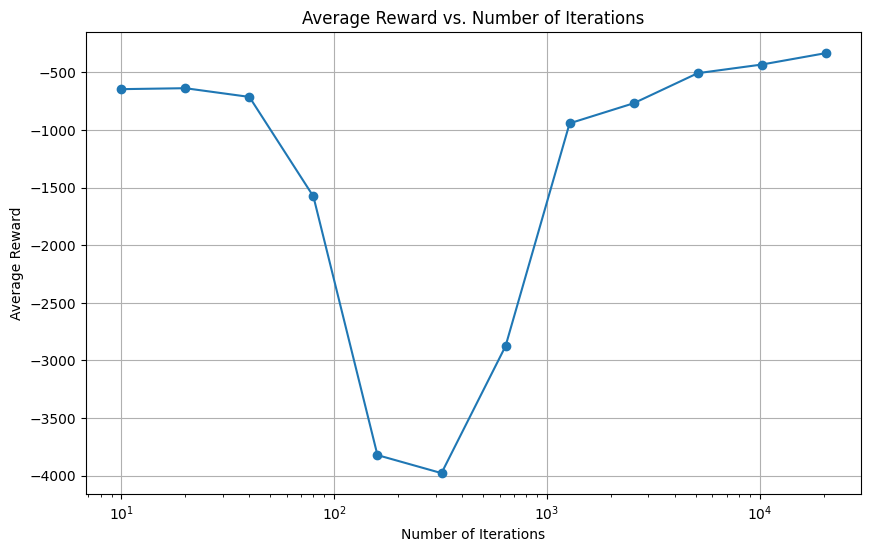

In [172]:
iterations_list = [10, 20, 40, 80, 160, 320, 640, 1280, 2560, 5120, 10240,20480]
num_test_episodes = 100
num_subiter = 5

average_rewards = {}

for iterations in iterations_list:
    rewards = []
    for _ in range(num_subiter):
        SARSA_q_table = SARSA_Agent(
            alpha=0.1, gamma=0.9, env=env, epsilon=0.5, epsilon_decay=0.999, epsilon_min=0.01
        ).train(iterations)

        average_reward, _ = evaluate_q_table(SARSA_q_table, env, num_episodes=num_test_episodes)
        rewards.append(average_reward)
    average_rewards[iterations] = np.mean(rewards)

plt.figure(figsize=(10, 6))
plt.plot(list(average_rewards.keys()), list(average_rewards.values()), marker='o')
plt.xscale('log')
plt.xlabel('Number of Iterations')
plt.ylabel('Average Reward')
plt.title('Average Reward vs. Number of Iterations')
plt.grid(True)
plt.show()

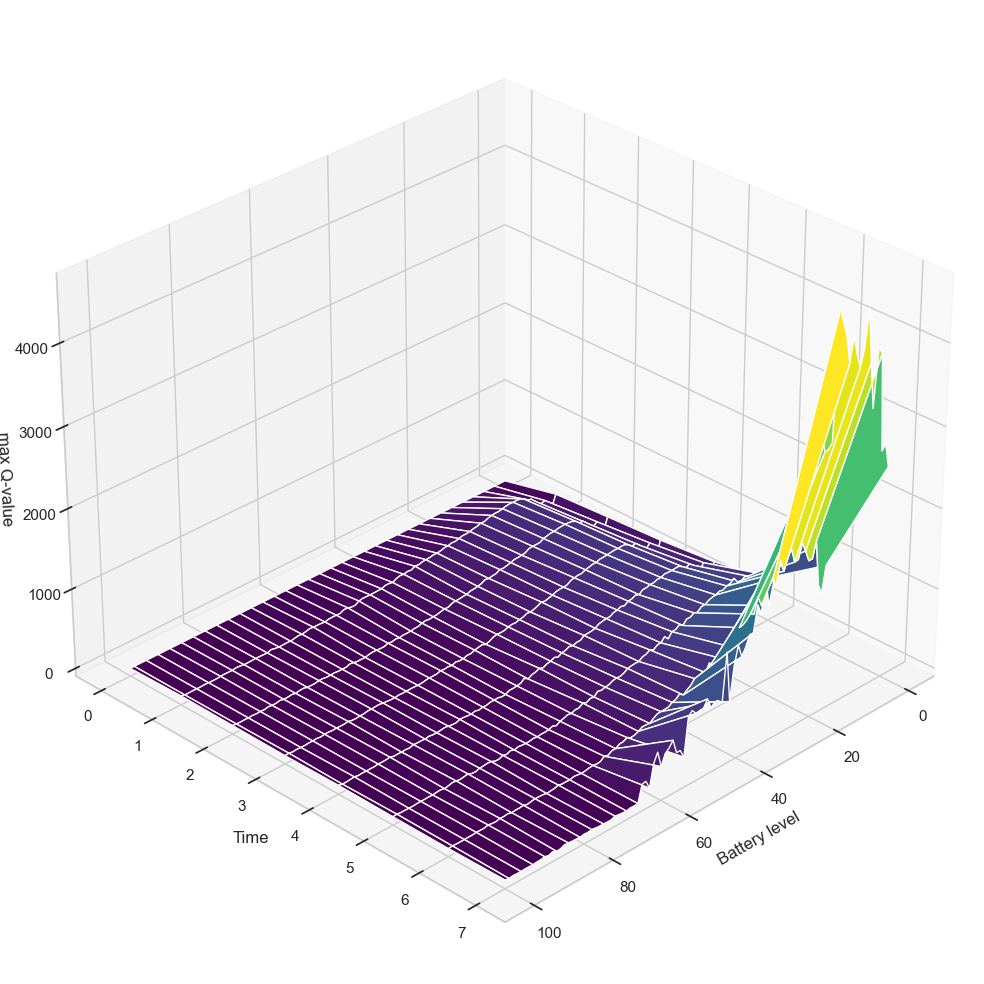

In [638]:
plot_q_table_3d(QLEARN_q_table,env.cap)

In [636]:
def q_table_to_dataframe(q_table, actions, max_time, max_level):
    data = []

    for time in range(max_time + 1):
        for level in range(max_level + 1):
            q_values = q_table.get((time, level), [0] * len(actions))
            max_action_index = np.argmax(q_values)
            max_action_kwh = actions[max_action_index]
            data.append({
                'Time': time,
                'Battery_level': level,
                'Best_action_kwh': max_action_kwh,
                'Future_battery_level': level + max_action_kwh  if level + max_action_kwh < max_level else max_level
            })
    
    return pd.DataFrame(data)

max_time = 7
max_level = env.cap
actions = {0: 0, 1: 3, 2: 7, 3: 11, 4: 17}
df = q_table_to_dataframe(MC_q_table, actions, max_time, max_level)
df

unique_actions = df['Best_action_kwh'].unique()
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_actions)))
color_map = {action: f'rgb{tuple((c[:3] * 255).astype(int))}' for action, c in zip(unique_actions, colors)}


fig = go.Figure()
for action in unique_actions:
    action_data = df[df['Best_action_kwh'] == action]
    
    for i in range(len(action_data) - 1):
        x_values = [action_data.iloc[i]['Time'], action_data.iloc[i]['Time']+1]
        y_values = [action_data.iloc[i]['Battery_level'], action_data.iloc[i]['Future_battery_level']]
        
        if(i==0):
            scatters = go.Scatter(
                x=x_values,
                y=y_values,
                mode='lines+markers',
                line=dict(width=2, color=color_map.get(action, 'gray')),
                name=f'Action {action}'
            )
        else:
            scatters = go.Scatter(
                x=x_values,
                y=y_values,
                mode='lines+markers',
                line=dict(width=2, color=color_map.get(action, 'gray')),
                name=f'Action {action}',
                showlegend=False
            )
    
        fig.add_trace(scatters)

# Update layout
fig.update_layout(
    title='Battery Level Transitions Over Time',
    xaxis_title='Time',
    yaxis_title='Battery Level'
)

# Show the plot
fig.show()

Monte Carlo, Q-learning (double) , Deep Q-Network, SARSA